# 가설4: 마케팅 효율 분석
- 4-1: 오프라인 마케팅보다 온라인 마케팅이 더 높은 ROI(Return on Investment)를 제공할 것이다.

    → if True : 오프라인 마케팅 비용을 줄이고, 온라인 마케팅에 더 투자한다.

    else 온라인 마케팅 비용을 줄이고, 오프라인 마케팅에 더 투자한다.

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글깨짐 해결
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [205]:
customer_df = pd.read_csv('archive\Customers_Data.csv')
discount_coupon_df = pd.read_csv('archive\Discount_Coupon.csv')
marketing_spend_df = pd.read_csv('archive\Marketing_Spend.csv')
online_sales_df = pd.read_csv('archive\Online_Sales_edit.csv')
tax_amount_df = pd.read_csv('archive\Tax_Amount.csv')

### 살펴볼 데이터
1. 온라인 마케팅비용 → 일자별로 제공됨
2. 오프라인 마케팅비용 → 일자별로 제공됨
3. 일자별 매출 → 매출액 = 평균가*(1-GST) * 판매량 * (1-할인률) + 배송비
4. 일자별 주문건수 → 마케팅 효과를 위한 분석이므로, 주문 건수를 비교한다.

In [206]:
# marketing_spend_df
# online_sales_df
discount_coupon_df

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20
...,...,...,...,...
199,Nov,Notebooks & Journals,NJ20,20
200,Dec,Notebooks & Journals,NJ30,30
201,Oct,Android,AND10,10
202,Nov,Android,AND20,20


### 전처리과정
1. 온라인 매출 - 쿠폰 - Tax → 병합
2. 매출액 컬럼 생성 → 매출액 = 평균가 * (1-GST) * 판매량 * (1-할인률) + 배송비
3. 일자별 매출 가공
4. 일자별 매출 & 일자별 광고비 → 병합
5. 일자별 ROI 가공 (총광고/온라인/오프라인) → ROI = 매출액/광고비

#### 1. 온라인 매출 - 쿠폰 - Tax → 병합

In [207]:
# 필요한 컬럼만 추출
online_sales_df = online_sales_df[["Transaction_Date","Product_Category","Quantity","Avg_Price","Delivery_Charges","Coupon_Status"]]
# 병합을 위한 Month 컬럼 생성
format='%m/%d/%Y'
online_sales_df['Month'] = pd.to_datetime(online_sales_df['Transaction_Date'], format=format).dt.month_name().str.slice(stop=3)

# 불필요한 컬럼 제외
discount_coupon_df = discount_coupon_df.loc[:, discount_coupon_df.columns != 'Coupon_Code']

# Unique key를 위해 두 가지 컬럼을 기준으로 병합 - sales&coupon
merged = pd.merge(online_sales_df,discount_coupon_df,on=["Product_Category","Month"])
# 병합 - sales&coupon&tax
merged = pd.merge(merged,tax_amount_df,on=["Product_Category"])
merged


,Transaction_Date,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST
0,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%
1,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%
2,1/1/2019,Office,1,2.05,6.50,Used,Jan,10,10%
3,1/1/2019,Apparel,5,17.53,6.50,Not Used,Jan,10,18%
4,1/1/2019,Bags,1,16.50,6.50,Used,Jan,10,18%
...,...,...,...,...,...,...,...,...,...
52519,12/31/2019,Nest-USA,1,121.30,6.50,Clicked,Dec,30,10%
52520,12/31/2019,Apparel,1,48.92,6.50,Used,Dec,30,18%
52521,12/31/2019,Nest-USA,1,151.88,6.50,Used,Dec,30,10%
52522,12/31/2019,Nest-USA,5,80.52,6.50,Clicked,Dec,30,10%


#### 2. 매출액 컬럼 생성 → 매출액 = 평균가 * (1-GST) * 판매량 * (1-할인률) + 배송비

In [208]:
Avg_Price = merged['Avg_Price']
Quantity = merged['Quantity']
Delivery_Charges = merged['Delivery_Charges']
tax = merged['GST'].str.rstrip('%').astype(float)/100 # str → float
# Coupon_Status == 'Used'일 경우만 적용. 이외에는 0으로 치환하여 할인률 미적용
Discount_pct = np.where(merged['Coupon_Status'] == 'Used', merged['Discount_pct']/100, 0)
# 매출액 정의
sales_df = Avg_Price*(1-tax)*Quantity*(1-Discount_pct) + Delivery_Charges
# 매출액 컬럼 추가
merged['sales'] = sales_df

merged

,Transaction_Date,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,sales
0,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%,131.00510
1,1/1/2019,Nest-USA,1,153.71,6.50,Used,Jan,10,10%,131.00510
2,1/1/2019,Office,1,2.05,6.50,Used,Jan,10,10%,8.16050
3,1/1/2019,Apparel,5,17.53,6.50,Not Used,Jan,10,18%,78.37300
4,1/1/2019,Bags,1,16.50,6.50,Used,Jan,10,18%,18.67700
...,...,...,...,...,...,...,...,...,...,...
52519,12/31/2019,Nest-USA,1,121.30,6.50,Clicked,Dec,30,10%,115.67000
52520,12/31/2019,Apparel,1,48.92,6.50,Used,Dec,30,18%,34.58008
52521,12/31/2019,Nest-USA,1,151.88,6.50,Used,Dec,30,10%,102.18440
52522,12/31/2019,Nest-USA,5,80.52,6.50,Clicked,Dec,30,10%,368.84000


#### 3. 일자별 매출 가공

In [209]:
daily_sales_df = merged.groupby('Transaction_Date')['sales'].sum().round(0).reset_index(name='sales') # 1의 자리까지 반올림

daily_sales_df

,Transaction_Date,sales
0,1/1/2019,7368.0
1,1/10/2019,16244.0
2,1/11/2019,11071.0
3,1/12/2019,11064.0
4,1/13/2019,14712.0
...,...,...
360,9/5/2019,10210.0
361,9/6/2019,12599.0
362,9/7/2019,14836.0
363,9/8/2019,5441.0


#### 4. 일자별 매출 & 일자별 광고비 → 병합

In [210]:
daily_sales_df.columns = ['Date', 'sales'] # 병합을 위해 컬럼명 통일

daily_ROI_df = pd.merge(marketing_spend_df,daily_sales_df,on=["Date"],how='left')

daily_ROI_df

,Date,Offline_Spend,Online_Spend,sales
0,1/1/2019,4500,2424.50,7368.0
1,1/2/2019,4500,3480.36,12388.0
2,1/3/2019,4500,1576.38,24176.0
3,1/4/2019,4500,2928.55,15580.0
4,1/5/2019,4500,4055.30,17227.0
...,...,...,...,...
360,12/27/2019,4000,3396.87,12084.0
361,12/28/2019,4000,3246.84,9583.0
362,12/29/2019,4000,2546.58,10252.0
363,12/30/2019,4000,674.31,7174.0


#### 5. 일자별 ROI 가공 (총광고/온라인/오프라인) → ROI = 매출액/광고비

In [211]:
# 매출액/광고비 변수 정의
sales = daily_ROI_df["sales"]
total_spend = daily_ROI_df["Offline_Spend"]+daily_ROI_df["Online_Spend"]
offline_spend,online_spend = daily_ROI_df["Offline_Spend"],daily_ROI_df["Online_Spend"]
cost = [total_spend,offline_spend,online_spend]
# total_spend 컬럼생성
daily_ROI_df['total_spend'] = total_spend
# ROI 정의
total_ROI = round(sales/cost[0]*100,0)
offline_ROI = round(sales/cost[1]*100,0)
online_ROI = round(sales/cost[2]*100,0)
# ROI 컬럼생성
daily_ROI_df['total_ROI'] = total_ROI
daily_ROI_df['offline_ROI'] = offline_ROI
daily_ROI_df['online_ROI'] = online_ROI

daily_ROI_df

,Date,Offline_Spend,Online_Spend,sales,total_spend,total_ROI,offline_ROI,online_ROI
0,1/1/2019,4500,2424.50,7368.0,6924.50,106.0,164.0,304.0
1,1/2/2019,4500,3480.36,12388.0,7980.36,155.0,275.0,356.0
2,1/3/2019,4500,1576.38,24176.0,6076.38,398.0,537.0,1534.0
3,1/4/2019,4500,2928.55,15580.0,7428.55,210.0,346.0,532.0
4,1/5/2019,4500,4055.30,17227.0,8555.30,201.0,383.0,425.0
...,...,...,...,...,...,...,...,...
360,12/27/2019,4000,3396.87,12084.0,7396.87,163.0,302.0,356.0
361,12/28/2019,4000,3246.84,9583.0,7246.84,132.0,240.0,295.0
362,12/29/2019,4000,2546.58,10252.0,6546.58,157.0,256.0,403.0
363,12/30/2019,4000,674.31,7174.0,4674.31,153.0,179.0,1064.0


### 분석과정
1. 마케팅비용이 증가할수록 매출이 증가하는지 확인 → 일자별 ROI 확인
2. 온라인 마케팅비중이 증가할수록 매출이 증가하는지 확인 → 일자별 온라인마케팅비중 확인

#### 1. 마케팅비용이 증가할수록 매출이 증가하는지 확인 → 일자별 ROI 확인

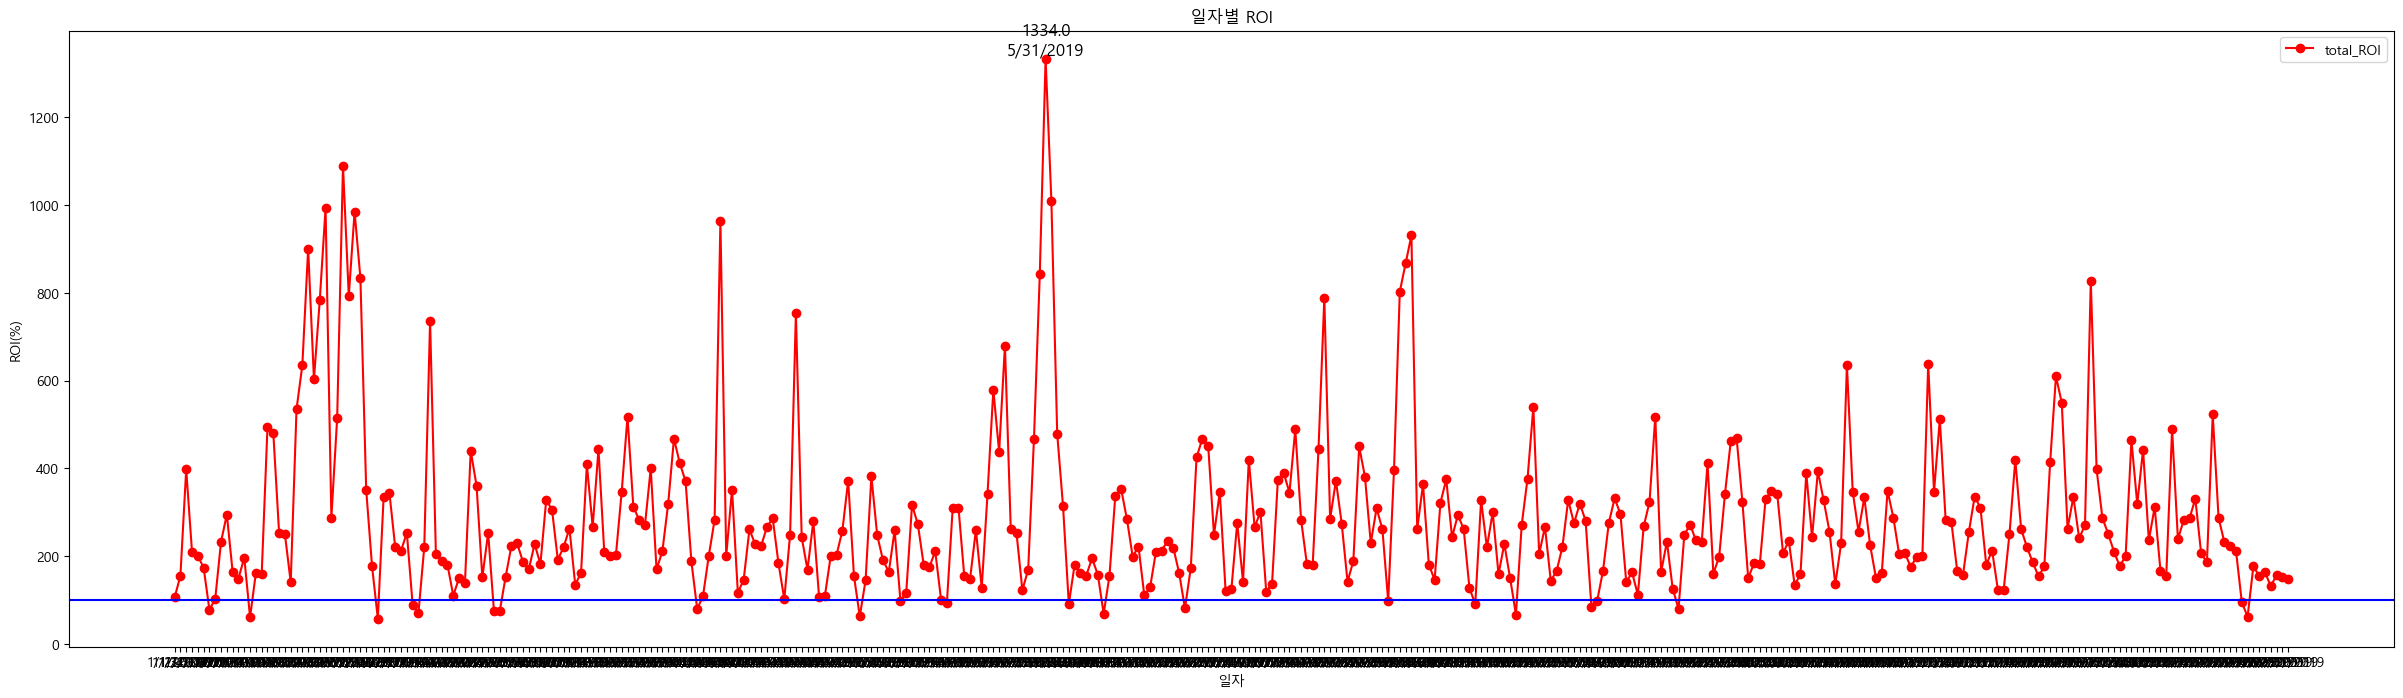

In [212]:
daily_ROI_df
    # <일자별 ROI plot 그래프>

#그래프 크기 설정 
plt.figure(figsize=(30,8))

#일자별 ROI plot
plt.plot(daily_ROI_df['Date'],daily_ROI_df['total_ROI'],color="red", label="total_ROI", marker='o')
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['offline_ROI'],color="blue", label="offline_ROI")
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['online_ROI'],color="green", label="online_ROI")

    # 데이터 포인트에 텍스트 추가
x,y = daily_ROI_df['Date'],daily_ROI_df['total_ROI']

    # 각 데이터 포인트에 텍스트 추가
# for i, roi in enumerate(y):
#     plt.text(x[i], y[i], f"{roi}\n{x[i]}", ha='center', va='bottom', size=12)

# 최대 ROI 값과 해당 인덱스 찾기
max_value = max(y)
max_index = y.argmax()

# 모든 데이터 포인트에 대해 반복하지 않고, 최대값에만 텍스트 추가
plt.text(x[max_index], y[max_index], f"{max_value}\n{x[max_index]}", ha='center', va='bottom', size=12)

# 100%에 파란색 수평선 추가 → 이 이상의 값들은 유의미한 광고효과가 발생함
plt.axhline(y=100, color='blue', linestyle='-')

#범례
plt.legend()

#그래프 타이틀
plt.title("일자별 ROI")

#x축 레이블
plt.xlabel('일자')

#y축 레이블 
plt.ylabel('ROI(%)')

#그래프 보여주기
plt.show()

In [213]:
import pandas as pd

# 두 변수 간의 상관 계수 계산
x = ['total_spend','Offline_Spend','Online_Spend']
for i in x:
    pearson_corr = daily_ROI_df['sales'].corr(daily_ROI_df[i], method='pearson')
    spearman_corr = daily_ROI_df['sales'].corr(daily_ROI_df[i], method='spearman')
    print(i)
    print(" 피어슨 상관 계수:", pearson_corr)
    print(" 스피어만 순위 상관 계수:", spearman_corr)


total_spend
 피어슨 상관 계수: 0.12044604328877963
 스피어만 순위 상관 계수: 0.10844119476481402
Offline_Spend
 피어슨 상관 계수: 0.11210924093672434
 스피어만 순위 상관 계수: 0.12503841562474674
Online_Spend
 피어슨 상관 계수: 0.08390395878494579
 스피어만 순위 상관 계수: 0.06237691186467331


#### 2. 온라인 마케팅비중이 증가할수록 매출이 증가하는지 확인 → 일자별 온라인마케팅비중 확인

In [222]:
daily_ROI_df["proportion_of_online"] = round(online_spend/total_spend*100,0)

daily_ROI_df

,Date,Offline_Spend,Online_Spend,sales,total_spend,total_ROI,offline_ROI,online_ROI,proportion_of_online
0,1/1/2019,4500,2424.50,7368.0,6924.50,106.0,164.0,304.0,65.0
1,1/2/2019,4500,3480.36,12388.0,7980.36,155.0,275.0,356.0,56.0
2,1/3/2019,4500,1576.38,24176.0,6076.38,398.0,537.0,1534.0,74.0
3,1/4/2019,4500,2928.55,15580.0,7428.55,210.0,346.0,532.0,61.0
4,1/5/2019,4500,4055.30,17227.0,8555.30,201.0,383.0,425.0,53.0
...,...,...,...,...,...,...,...,...,...
360,12/27/2019,4000,3396.87,12084.0,7396.87,163.0,302.0,356.0,54.0
361,12/28/2019,4000,3246.84,9583.0,7246.84,132.0,240.0,295.0,55.0
362,12/29/2019,4000,2546.58,10252.0,6546.58,157.0,256.0,403.0,61.0
363,12/30/2019,4000,674.31,7174.0,4674.31,153.0,179.0,1064.0,86.0


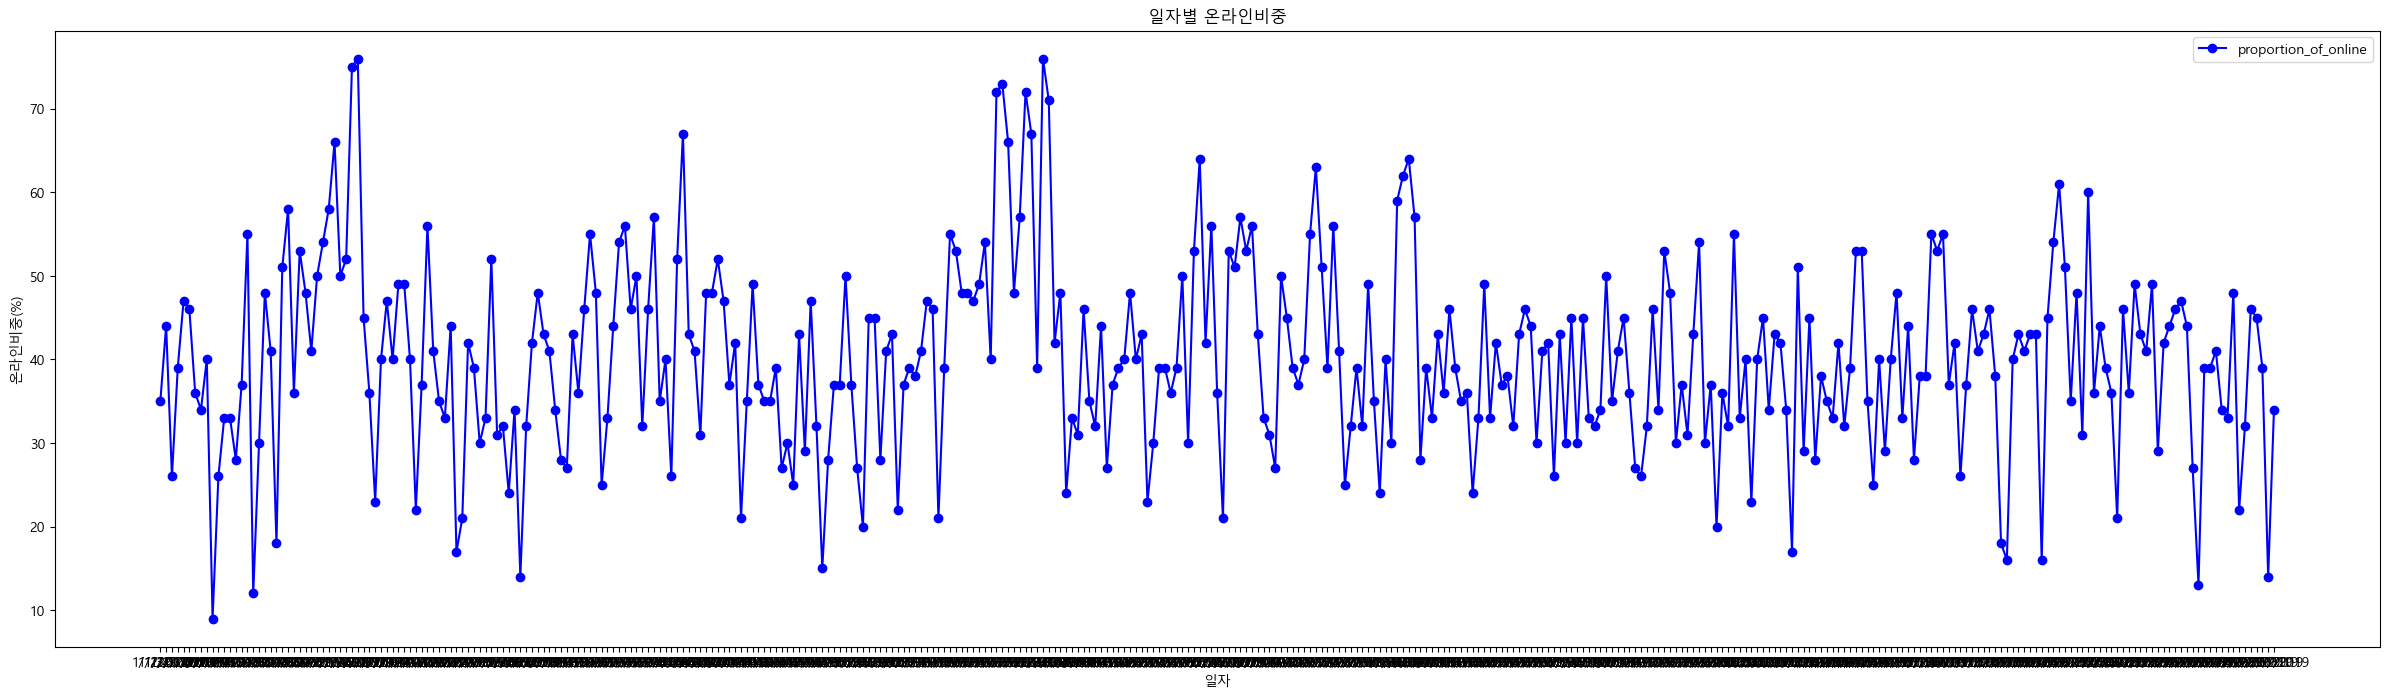

In [215]:
#그래프 크기 설정 
plt.figure(figsize=(30,8))

#일자별 ROI plot
plt.plot(daily_ROI_df['Date'],daily_ROI_df['proportion_of_online'],color="blue", label="proportion_of_online", marker='o')
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['offline_ROI'],color="blue", label="offline_ROI")
# plt.plot(daily_ROI_df['Date'],daily_ROI_df['online_ROI'],color="green", label="online_ROI")

#범례
plt.legend()

#그래프 타이틀
plt.title("일자별 온라인비중")

#x축 레이블
plt.xlabel('일자')

#y축 레이블 
plt.ylabel('온라인비중(%)')

#그래프 보여주기
plt.show()

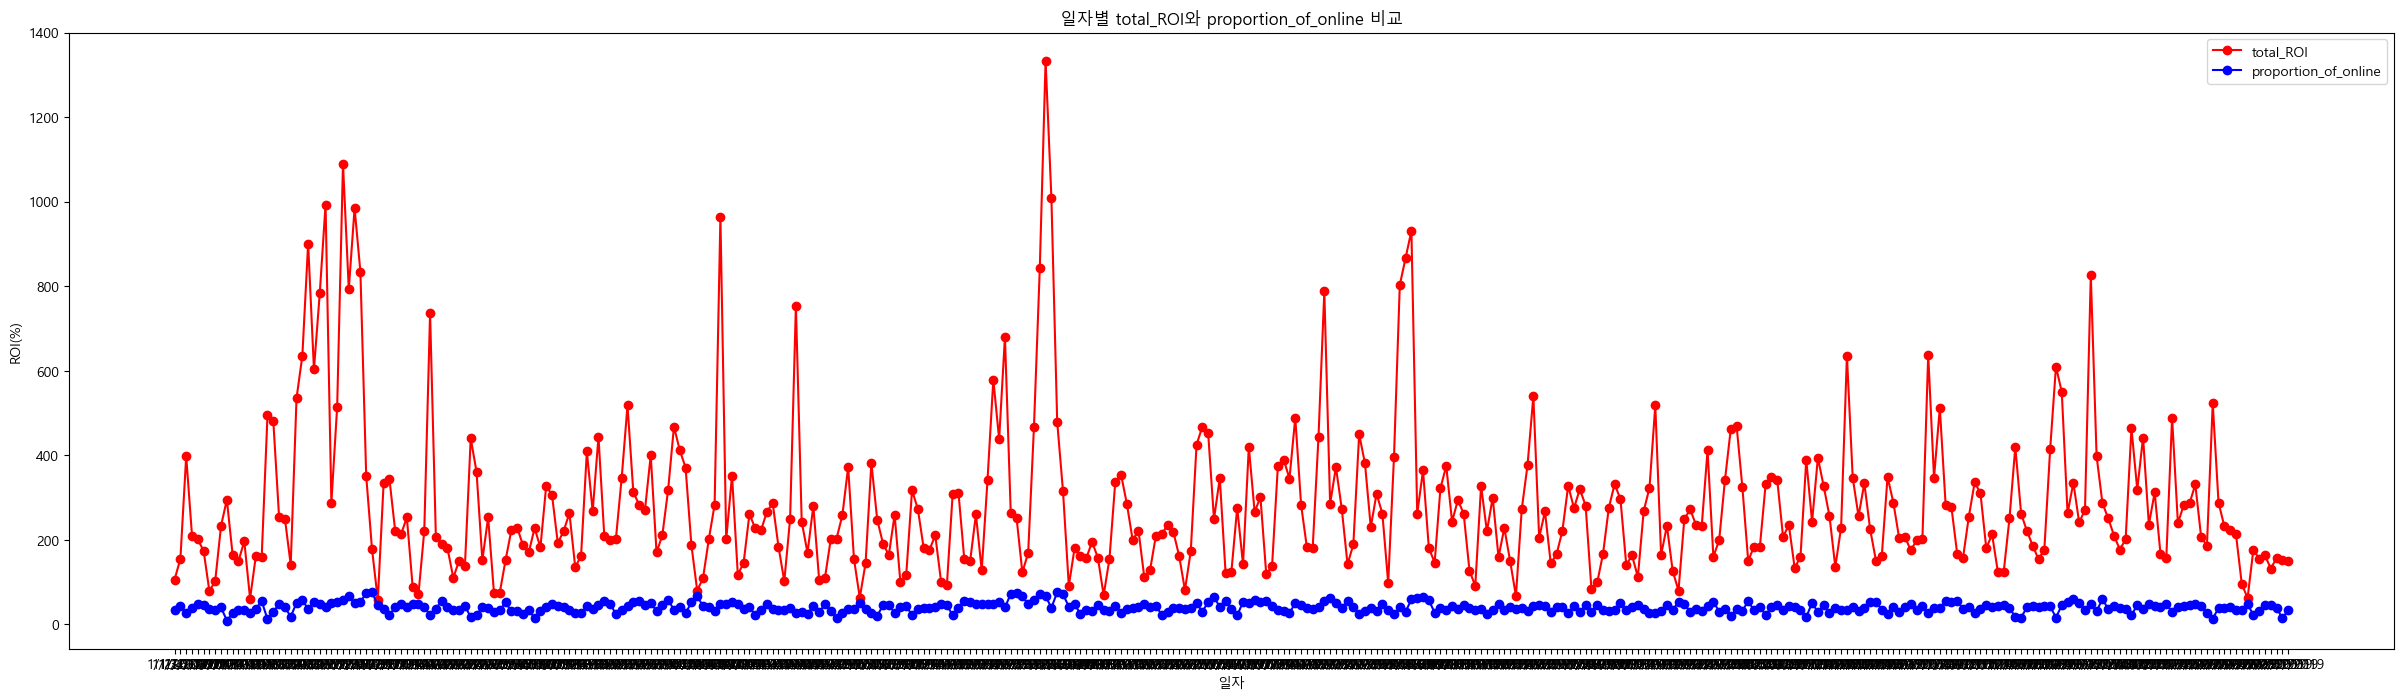

In [216]:
# 그래프 크기 설정
plt.figure(figsize=(30, 8))

# 일자별 total_ROI plot
plt.plot(daily_ROI_df['Date'], daily_ROI_df['total_ROI'], color="red", label="total_ROI", marker='o')

# 일자별 proportion_of_online plot
plt.plot(daily_ROI_df['Date'], daily_ROI_df['proportion_of_online'], color="blue", label="proportion_of_online", marker='o')

# 범례
plt.legend()

# 그래프 타이틀
plt.title("일자별 total_ROI와 proportion_of_online 비교")

# x축 레이블
plt.xlabel('일자')

# y축 레이블
plt.ylabel('ROI(%)')

# 그래프 보여주기
plt.show()


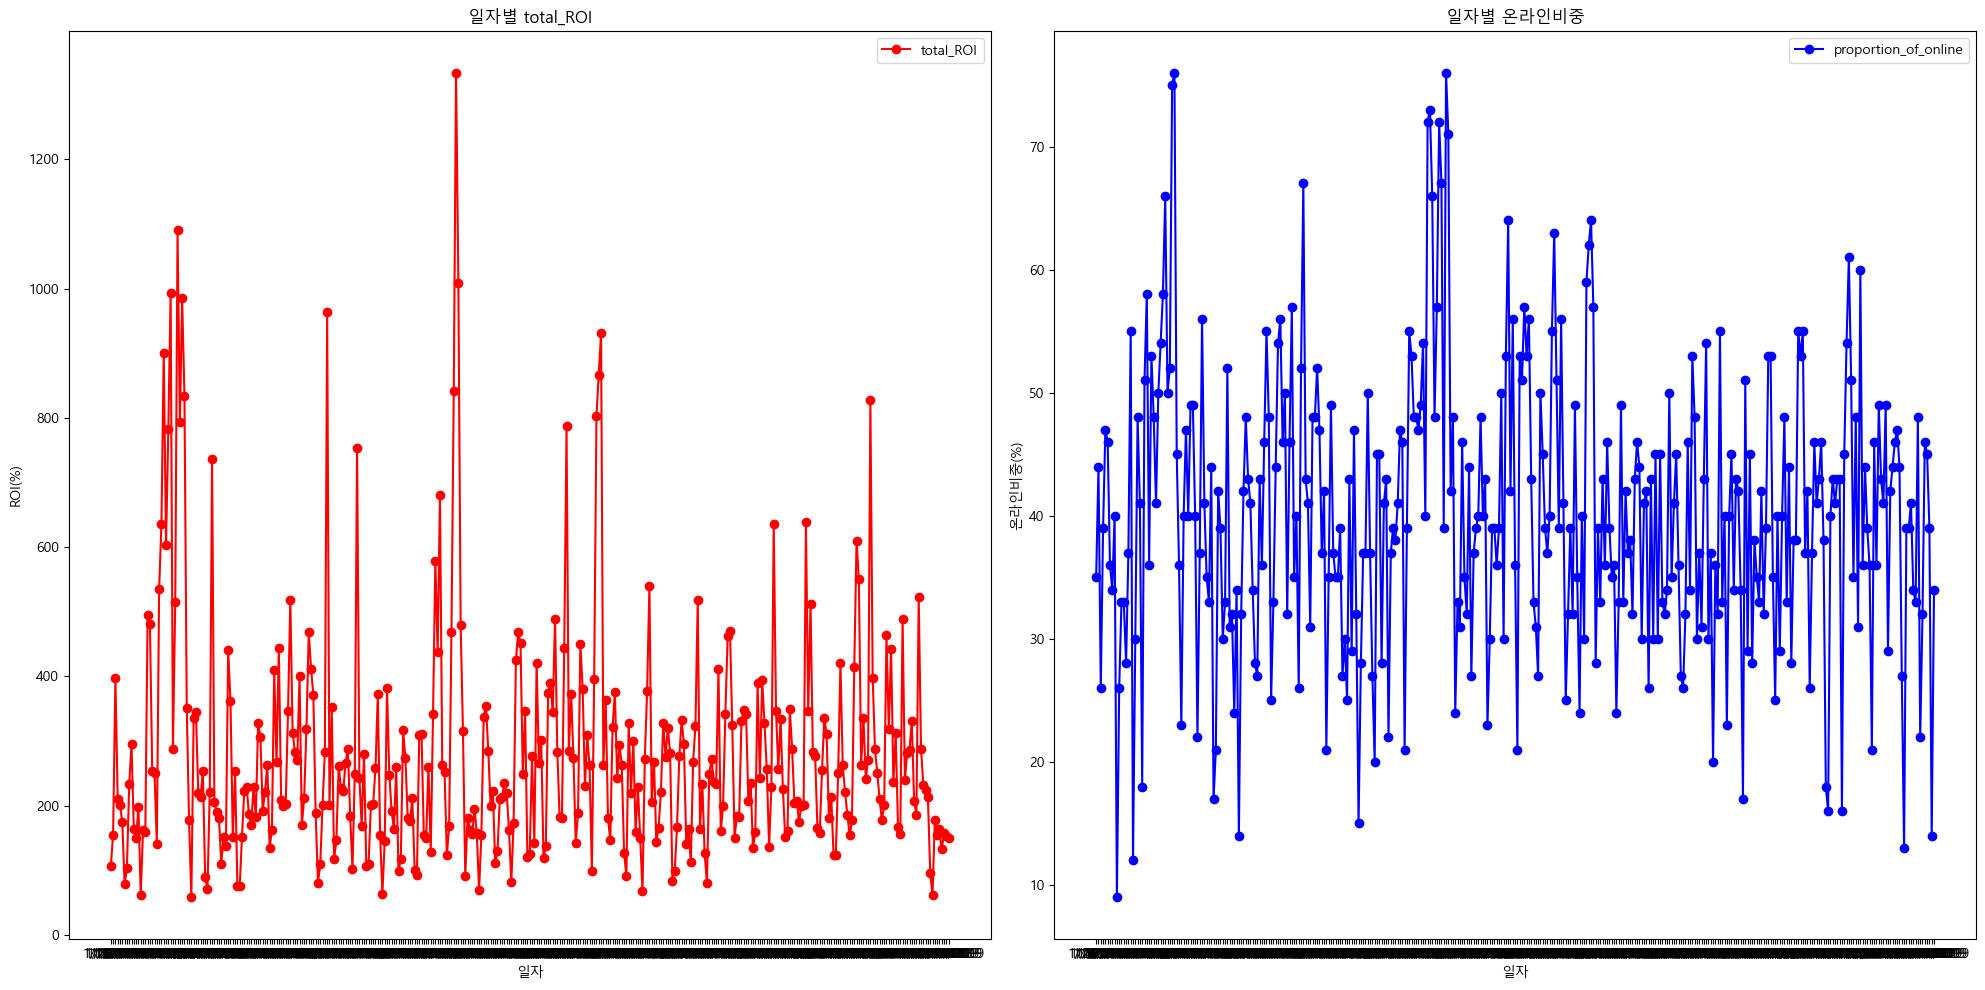

In [217]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(20, 10))

# 첫 번째 서브플롯: 일자별 total_ROI
plt.subplot(1, 2, 1) # 1행 2열의 첫 번째
plt.plot(daily_ROI_df['Date'], daily_ROI_df['total_ROI'], color="red", label="total_ROI", marker='o')
plt.title("일자별 total_ROI")
plt.xlabel('일자')
plt.ylabel('ROI(%)')
plt.legend()

# 두 번째 서브플롯: 일자별 proportion_of_online
plt.subplot(1, 2, 2) # 1행 2열의 두 번째
plt.plot(daily_ROI_df['Date'], daily_ROI_df['proportion_of_online'], color="blue", label="proportion_of_online", marker='o')
plt.title("일자별 온라인비중")
plt.xlabel('일자')
plt.ylabel('온라인비중(%)')
plt.legend()

# 그래프 보여주기
plt.tight_layout() # 서브플롯 간 간격 조정
plt.show()


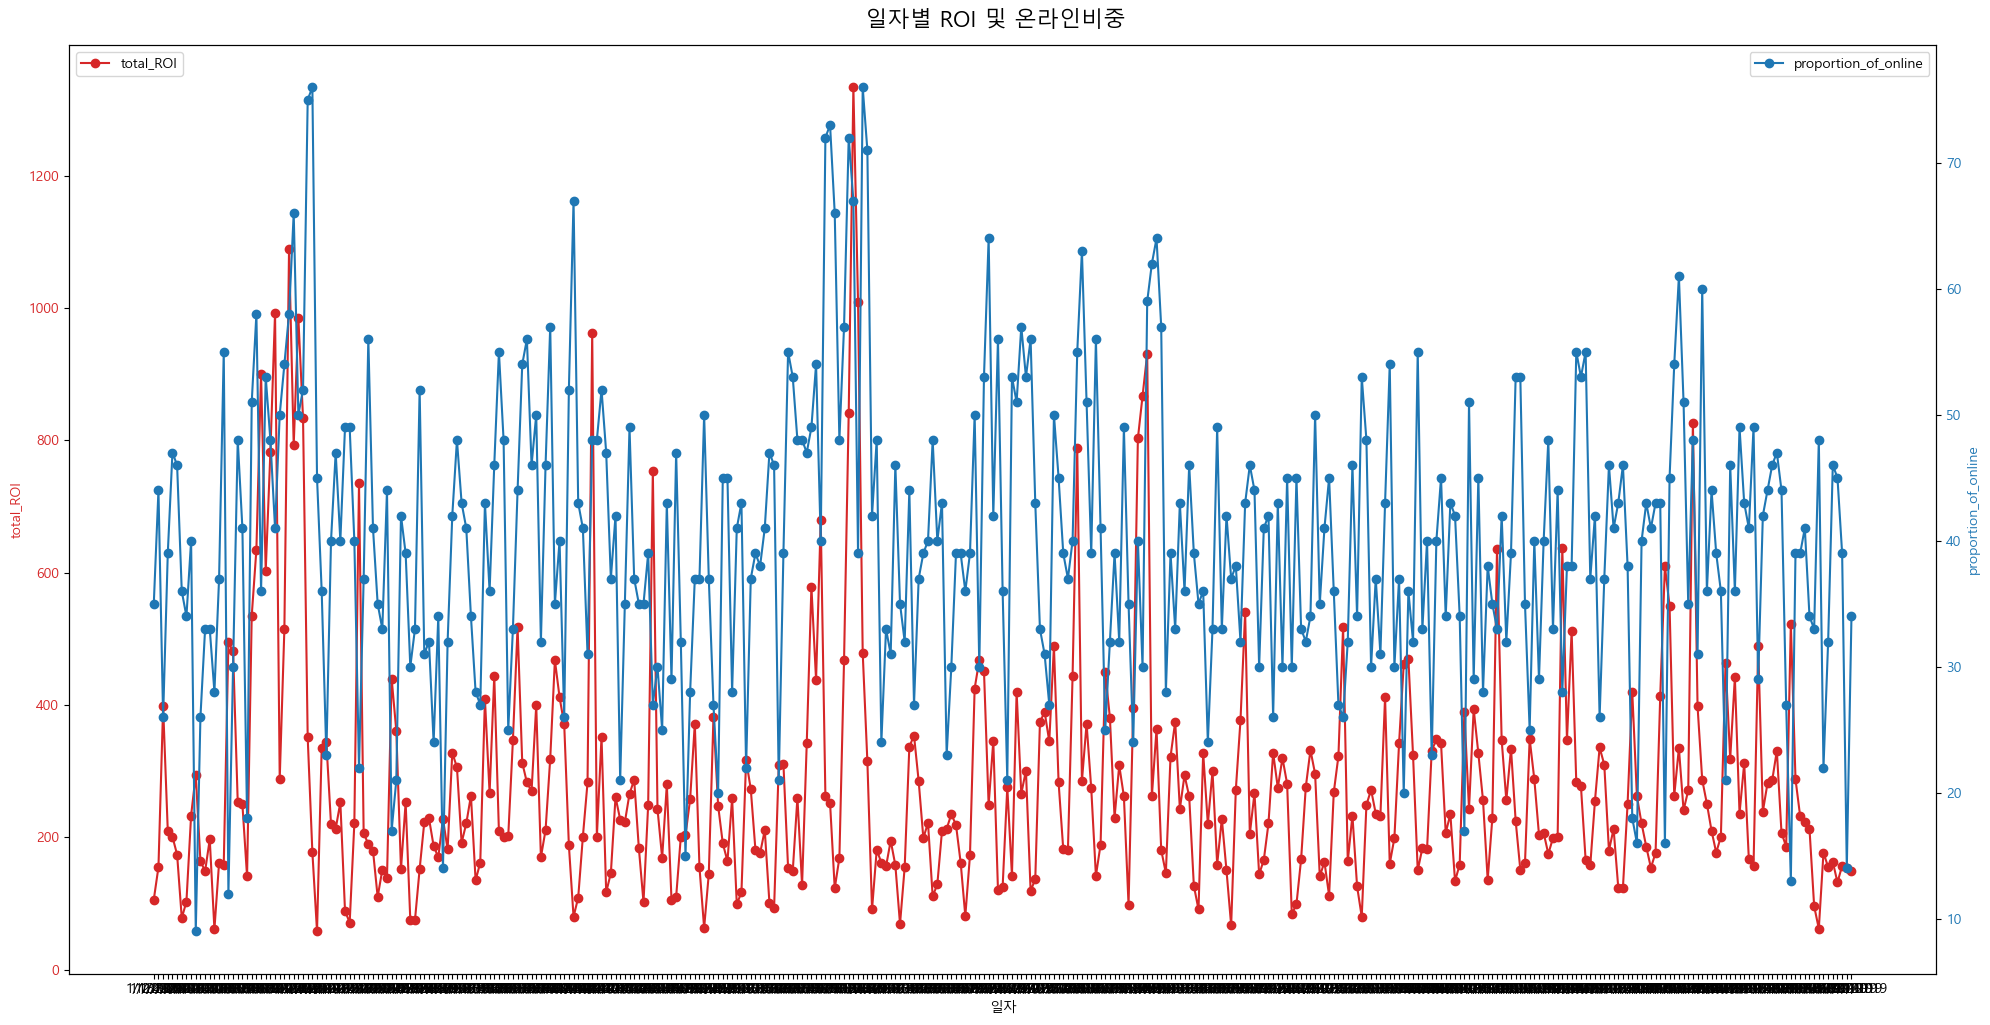

In [218]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(20, 10))

# 첫 번째 데이터 세트: 일자별 total_ROI
color = 'tab:red'
ax1.set_xlabel('일자')
ax1.set_ylabel('total_ROI', color=color)
ax1.plot(daily_ROI_df['Date'], daily_ROI_df['total_ROI'], color=color, label="total_ROI", marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# ax1과 x축을 공유하는 두 번째 y축 생성
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('proportion_of_online', color=color)  # 두 번째 데이터 세트의 y축 레이블
ax2.plot(daily_ROI_df['Date'], daily_ROI_df['proportion_of_online'], color=color, label="proportion_of_online", marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# 제목 및 범례 설정
fig.tight_layout()  # 레이아웃 조정
fig.suptitle('일자별 ROI 및 온라인비중', fontsize=16, y=1.02)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


상관관계 파악

In [223]:
import pandas as pd

# 두 변수 간의 상관 계수 계산
pearson_corr = daily_ROI_df['total_ROI'].corr(daily_ROI_df['proportion_of_online'], method='pearson')
spearman_corr = daily_ROI_df['total_ROI'].corr(daily_ROI_df['proportion_of_online'], method='spearman')

print("피어슨 상관 계수:", pearson_corr)
print("스피어만 순위 상관 계수:", spearman_corr)


피어슨 상관 계수: -0.08184258737734075
스피어만 순위 상관 계수: 0.022242112870089172


### 결론
Q1. 한정된 예산에서, 온라인/오프라인 중 어디에 집중해야 매출증대를 기대할 수 있는가?

    → ROI를 보았을 때, 상대적으로 온라인의 ROI가 큰 것을 볼 수 있다

### 우려되는 한계점
- ROI계산시, 매출액 중 온라인의 영향과 오프라인의 영향을 구분하여 계산할 수 없어. 절대적인 비용에 따라 결정된다.